# 미니 프로젝트 : Kaggle Leaderboard with House Price Prediction

캐글 경진대회인 2019 2nd ML month with KaKR 는 국내 최대 캐글 커뮤니티인 캐글코리아 (Kaggle Korea)가 2019년에 주최했던 대회이다.

Kaggle 에서 제공한 데이터는 20개의 변수를 가지고 있으며, 어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 모델을 만드는 것을 목표로 한다.

이 데이터를 깊게 탐색하는 __EDA 과정__ 을 통해 __Feature Engineering__ 을 진행한다.

이후 머신러닝을 활용해서 모델을 학습시키고 다양한 하이퍼 파라미터를 튜닝하며 최적의 조합을 찾아 성능을 극대화 하여 __Kaggle Learderboard__ 에서 랭킹을 확인해보자.

![image](https://user-images.githubusercontent.com/84179578/127451295-867d00d6-013d-48e4-91f8-e5016e0d0094.png)

## 0. 필요한 모듈 불러오기

In [33]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. 데이터 탐색

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
print(f'Training set : {train.shape}')
print(f'Test set : {test.shape}')

Training set : (15035, 21)
Test set : (6468, 20)


훈련 데이터와 테스트 데이터는 각각 약 15,000개, 6,500개 정도로 이루어져있고, 변수의 갯수가 20개 인 것을 확인 할 수 있다.  

여기서 훈련용 데이터는 21개의 column 이 존재하는 것을 보아 목표 변수인 `price` 가 포함 된 것을 알 수 있다.

각 변수는 다음과 같은 의미를 가지고 있다.
- `ID` : 집을 구분하는 번호
- `date` : 집을 구매한 날짜
- `price` : 타겟 변수인 집의 가격
- `bedrooms` : 침실의 수
- `bathrooms` : 침실당 화장실 개수
- `sqft_living` : 주거 공간의 평방 피트
- `sqft_lot` : 부지의 평방 피트
- `floors` : 집의 층수
- `waterfront` : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- `view` : 집이 얼마나 좋아 보이는지의 정도
- `condition` : 집의 전반적인 상태
- `grade` : King County grading 시스템 기준으로 매긴 집의 등급
- `sqft_above` : 지하실을 제외한 평방 피트
- `sqft_basement` : 지하실의 평방 피트
- `yr_built` : 집을 지은 년도
- `yr_renovated` : 집을 재건축한 년도
- `zipcode` : 우편번호
- `lat` : 위도
- `long` : 경도
- `sqft_living15` : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
- `sqft_lot15` : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  


이제 각 변수를 하나하나 살펴보면서 전처리해야 할 부분을 정리하겠다.

### 결측치 확인

In [4]:
for i in train.columns:
    print('{} : {}'.format(i, len(train.loc[pd.isnull(train[i]), i].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


결측치가 없는 것을 확인 할 수 있다.

### 목표변수 `price` : 집의 가격


seaborn 을 이용한 시각화를 통해 `price` 데이터의 분포를 확인하자.

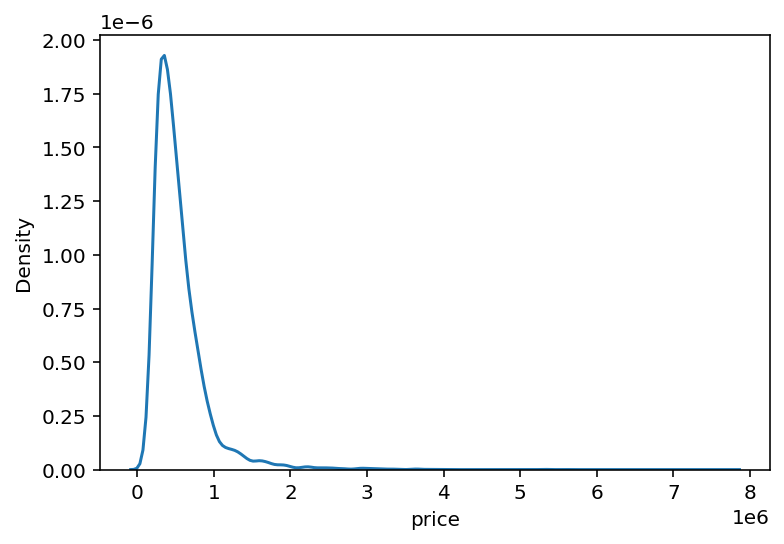

In [5]:
y = train['price']  # 목표변수를 y 에 저장

sns.kdeplot(y)
plt.show()

왼쪽으로 크게 치우쳐 있는 형태를 Normalize 를 통해 `price` 의 분포가 정규분포를 가지도록 해야할 필요성이 있다.  

np.log1p() 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.exp1m()을 활용해서 되돌리겠다.

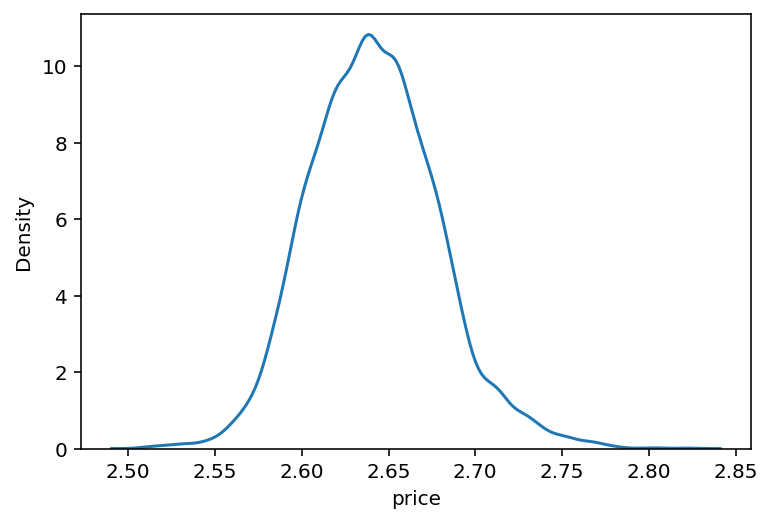

In [6]:
train['price'] = np.log1p(train['price'])

y = np.log1p(y)
sns.kdeplot(y)
plt.show()

## 변수 시각화

In [7]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


`id` 컬럼은 집 가격을 예측을 하는 데 필요하지 않은 정보이기 때문에 삭제한다.(1)

`date` 컬럼에서 연도와 월이 예측을 위해 필요한 특성으로 판단하여 정수형 데이터로 처리해야한다.(2)

아래는 각 변수간의 상관관계를 나타낸 히트맵이다.

<AxesSubplot:>

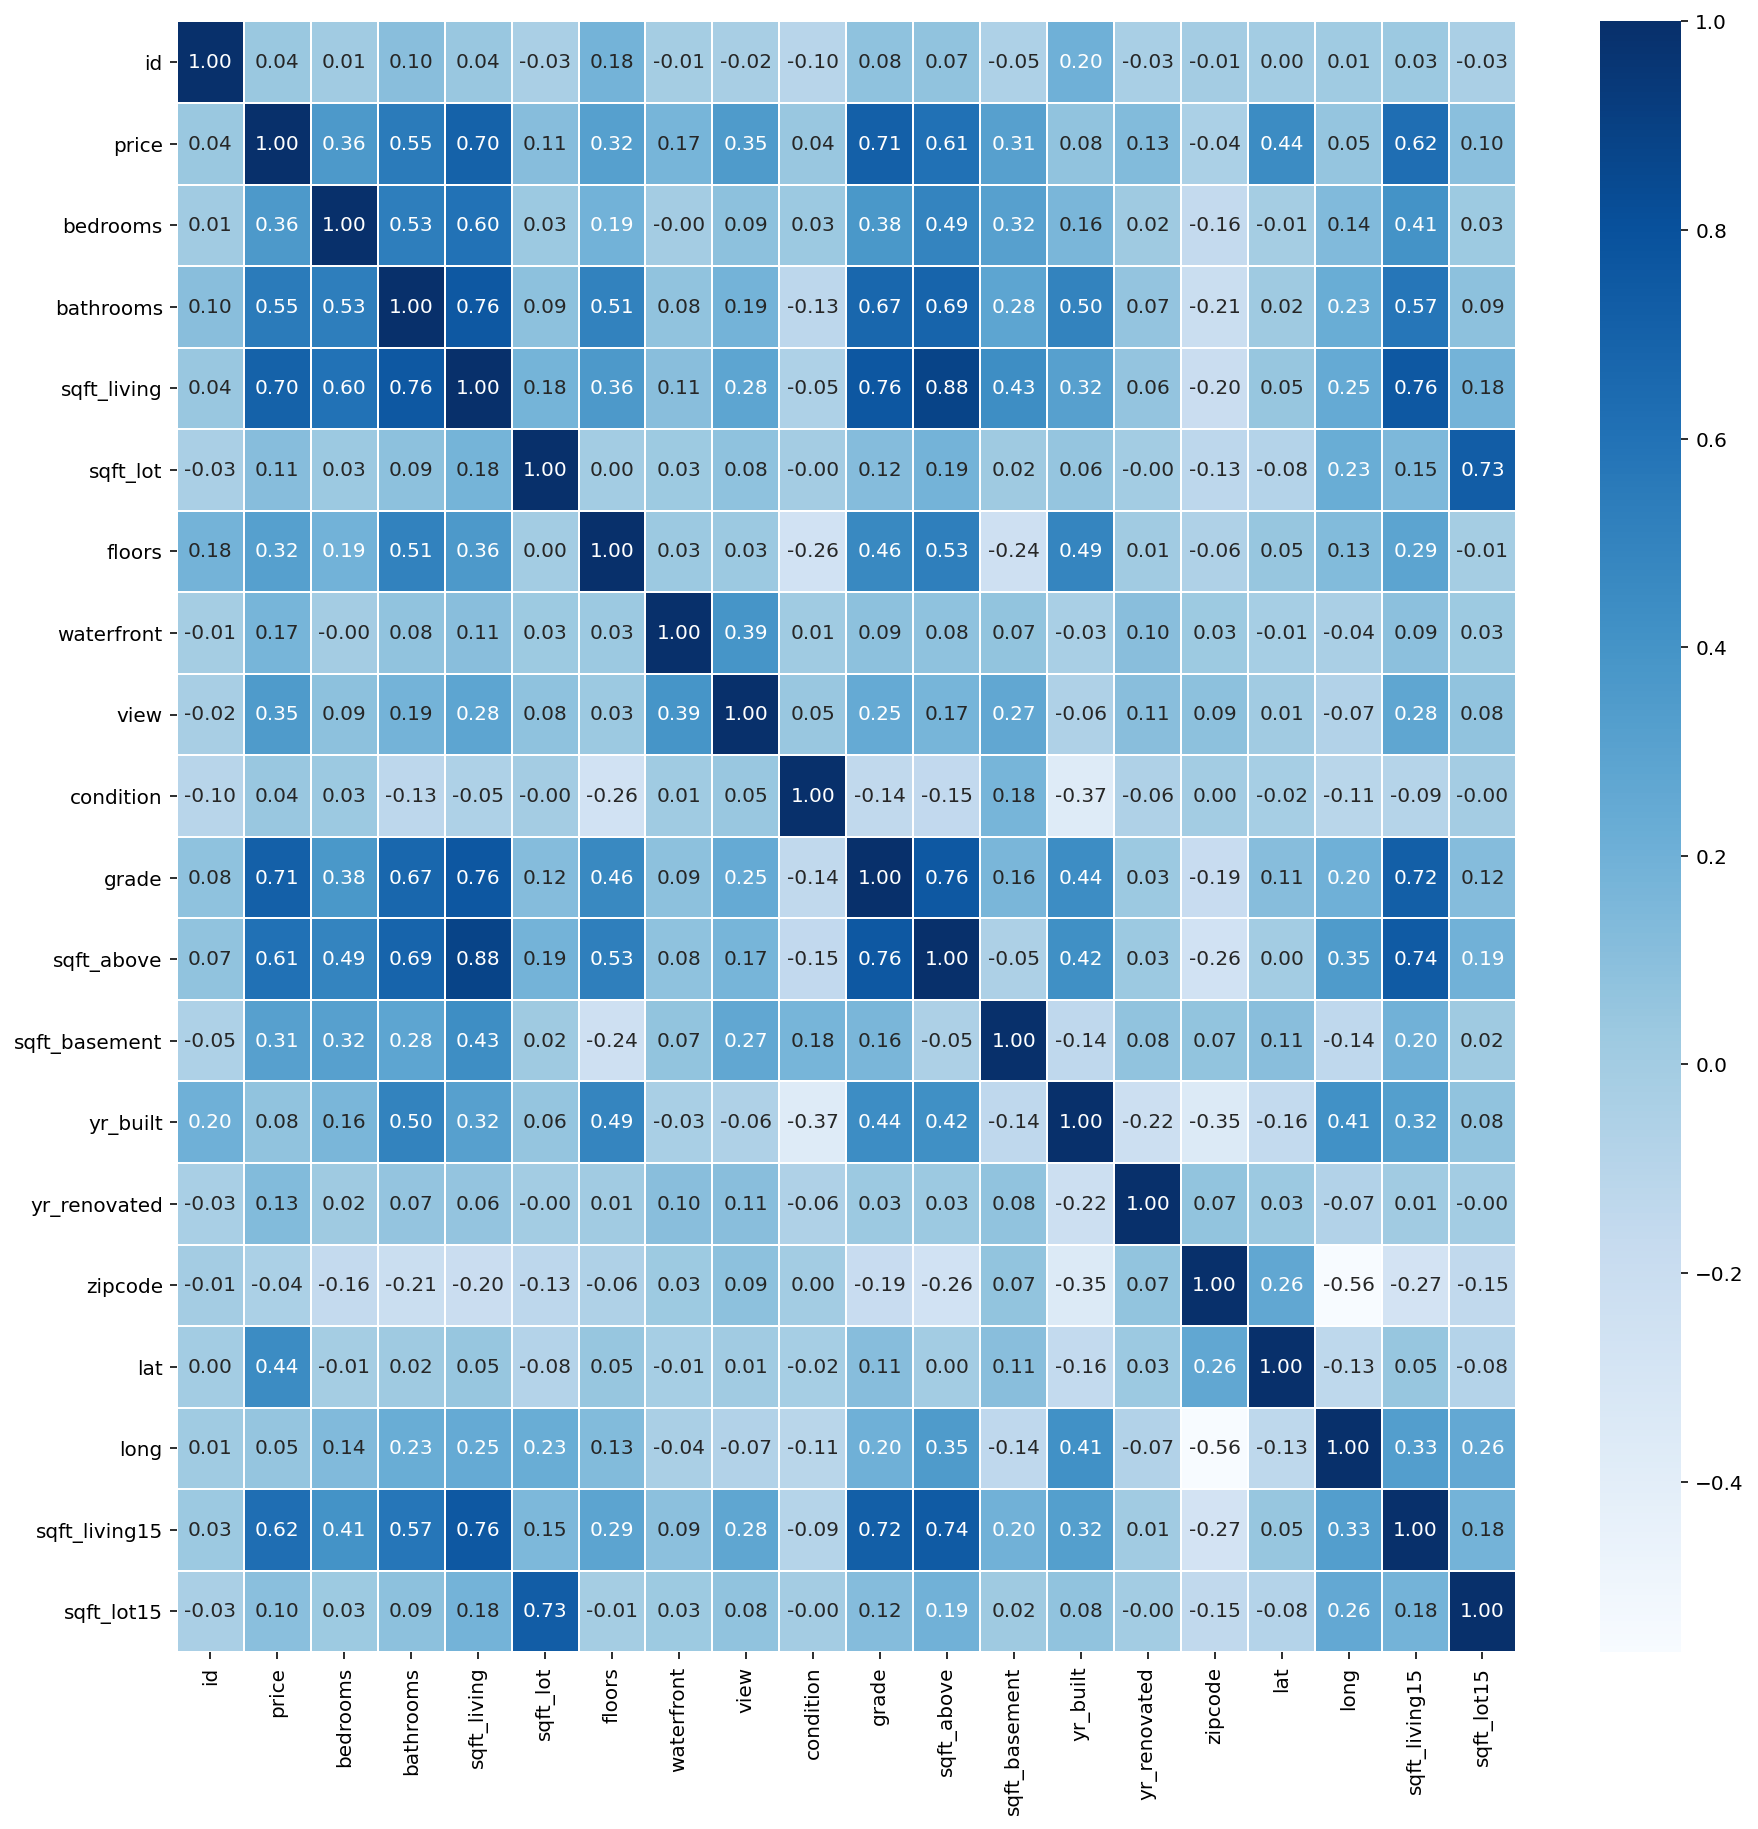

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

목표변수인 `price` 와 가장 상관관계가 높은 순으로 상위 5개만 보겠다.

In [9]:
corr = train.corr()
corr = corr.sort_values('price', ascending = False)
corr['price'].head(6)  # 첫번째는 price 자기 자신이므로 제외

price            1.000000
grade            0.707412
sqft_living      0.697907
sqft_living15    0.621800
sqft_above       0.607197
bathrooms        0.552000
Name: price, dtype: float64

주거 공간의 평방 면적, 집의 등급, 지하실을 제외한 평방 면적 등이 목표변수인 가격과 큰 상관 관계를 갖는 것을 알 수 있다.  

상관 관계가 비교적 큰 변수들을 시각화를 통해 살펴보겠다.

### `sqft_living` : 주거 공간의 평방 피트

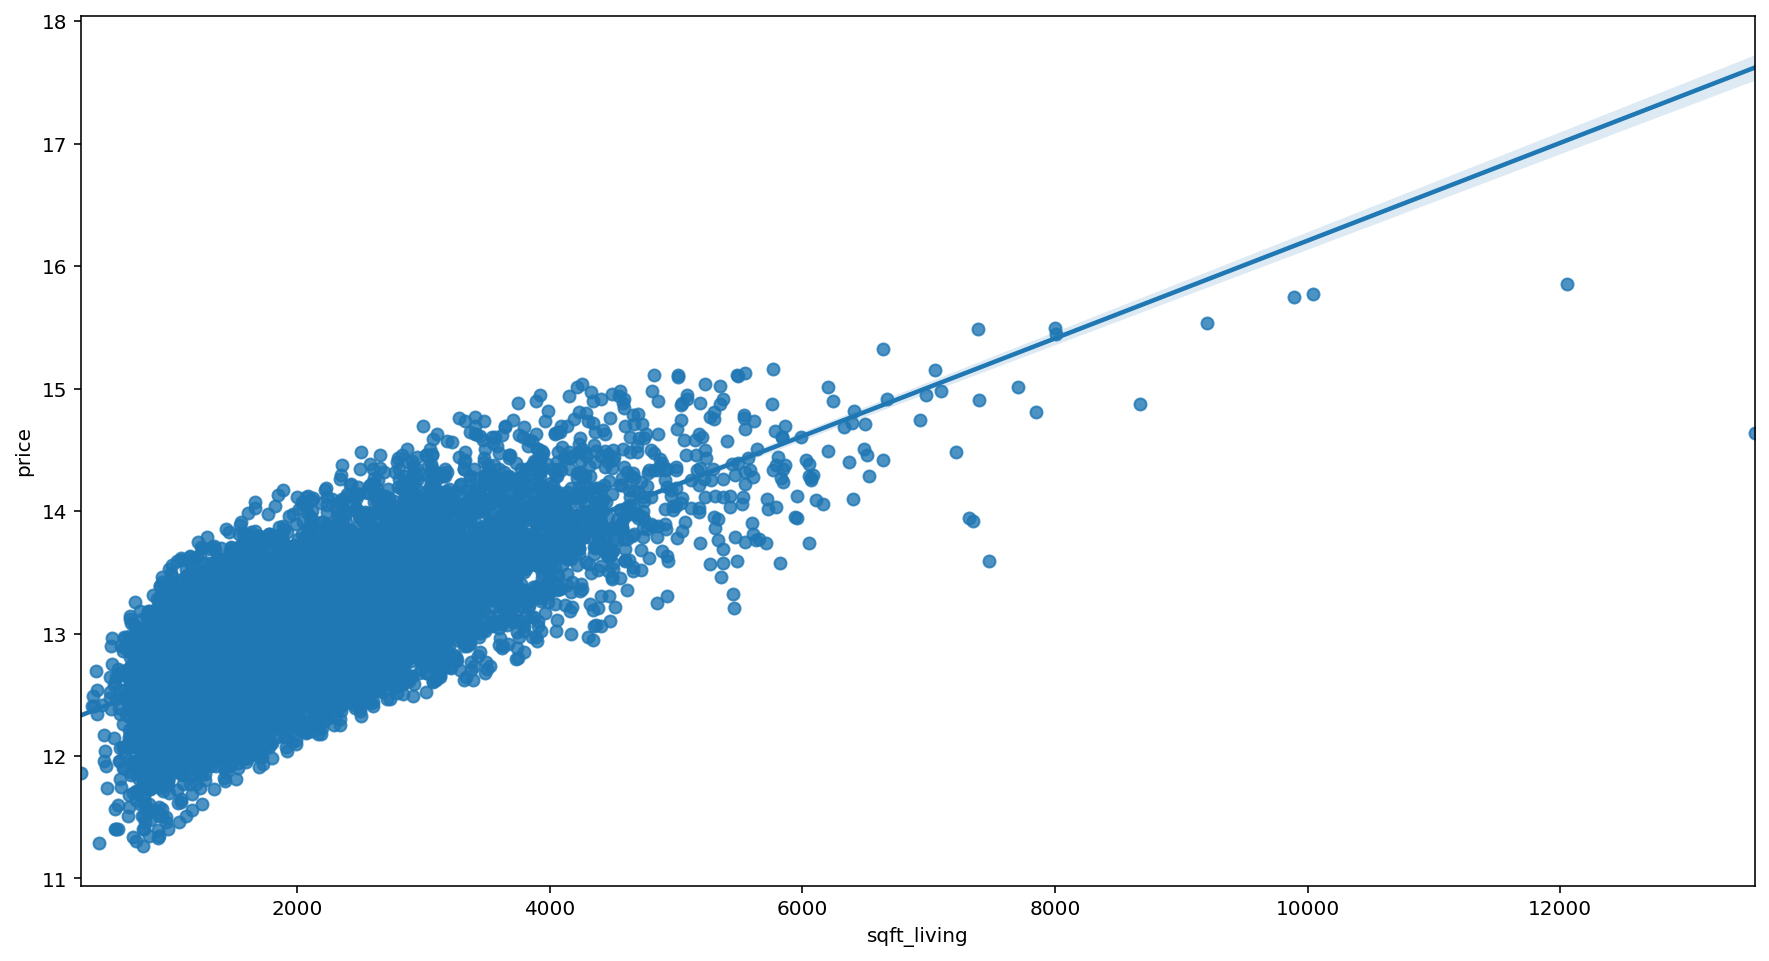

In [10]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(15, 8))
fig = sns.regplot(x='sqft_living', y="price", data=data)

전반적으로 선형성을 보이지만 가격이 약 14 정도에 sqft_living이 14000에 가까운 값은 이상치로 보인다. 이 이상치를 삭제해야한다.(3)

### `sqft_living15` : 주거 공간의 평방 피트(2015년 기준)

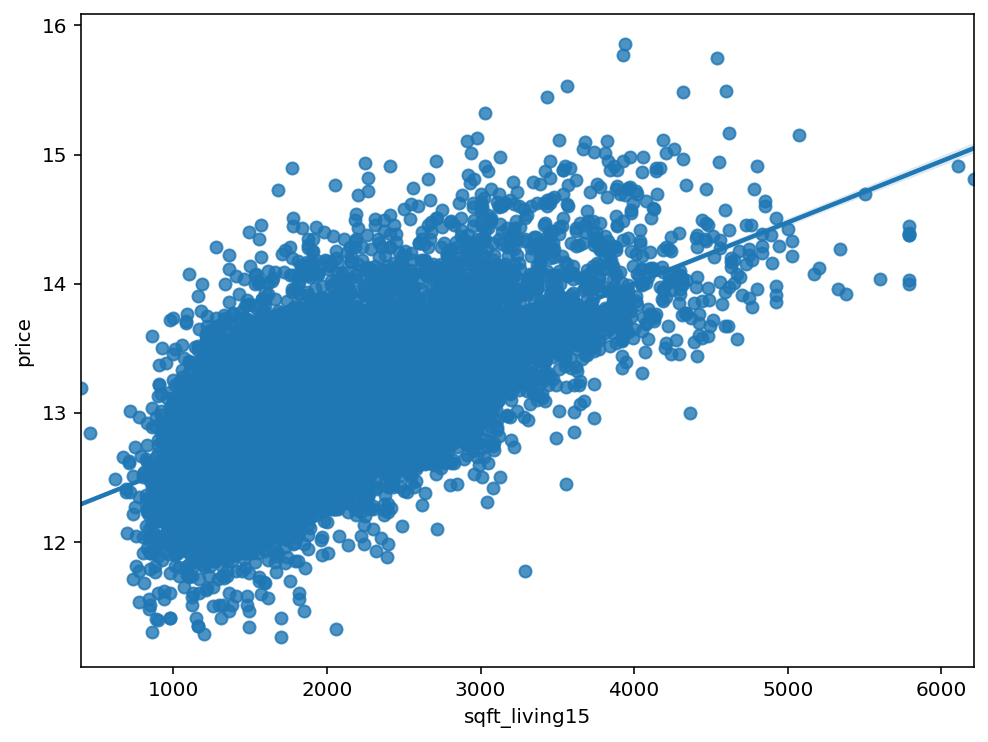

In [11]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

sqft_living15의 경우 15년도를 기준으로 했다보니 sqft_living에 비해 가격의 분산이 크다.

### `grade` : 집의 등급

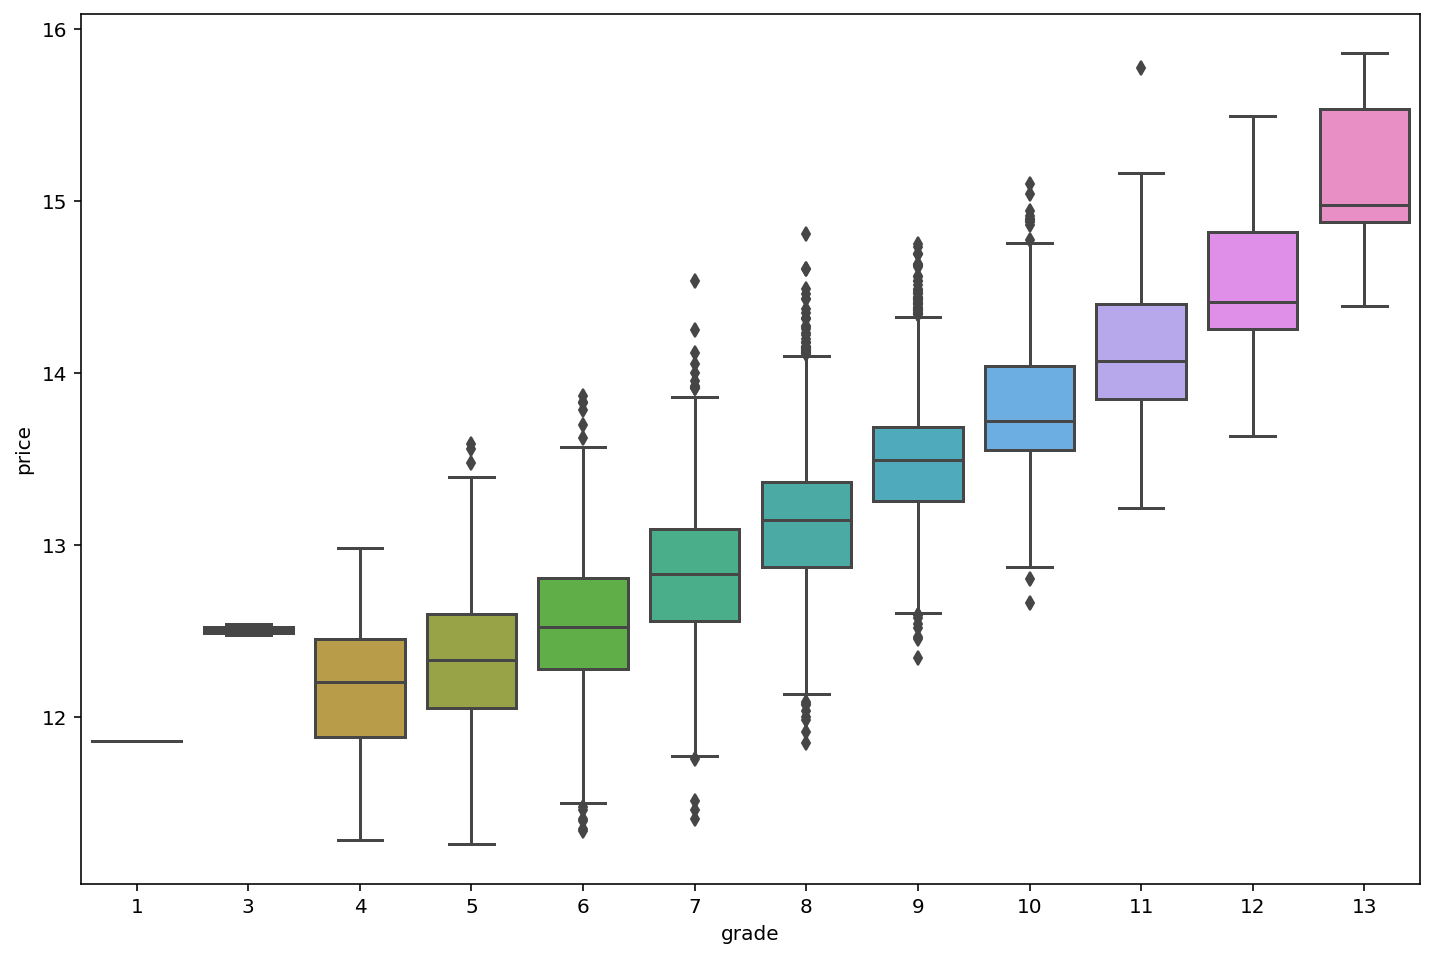

In [12]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x='grade', y="price", data=data)

grade의 경우 _"1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다."_ 라고 한다.  

일반적으로, 상승곡선의 형태를 가지며 집의 등급이 높을 수록 집 값이 비싸는 것을 확인할 있다.  

하지만 다음과 같은 점에 주목해야 할 필요가 있다.(4)
- 등급 3 의 경우 값이 큰 경우
- 등급 8과 11에서 차이가 큰 이상치가 나타나는 경우

### `sqft_above` : 지하실을 제외한 평방 피트

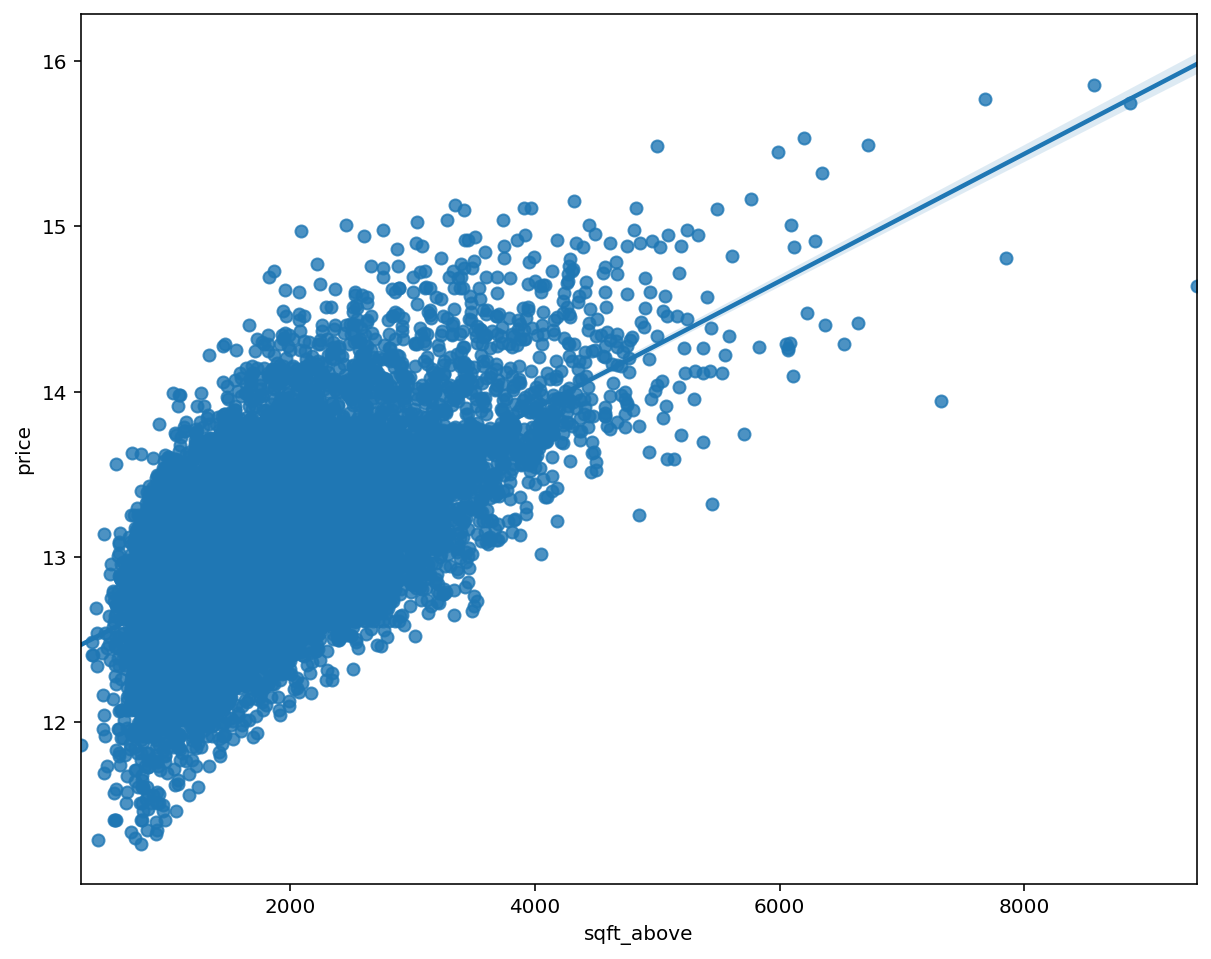

In [13]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.regplot(x='sqft_above', y="price", data=data)

### `bathrooms`

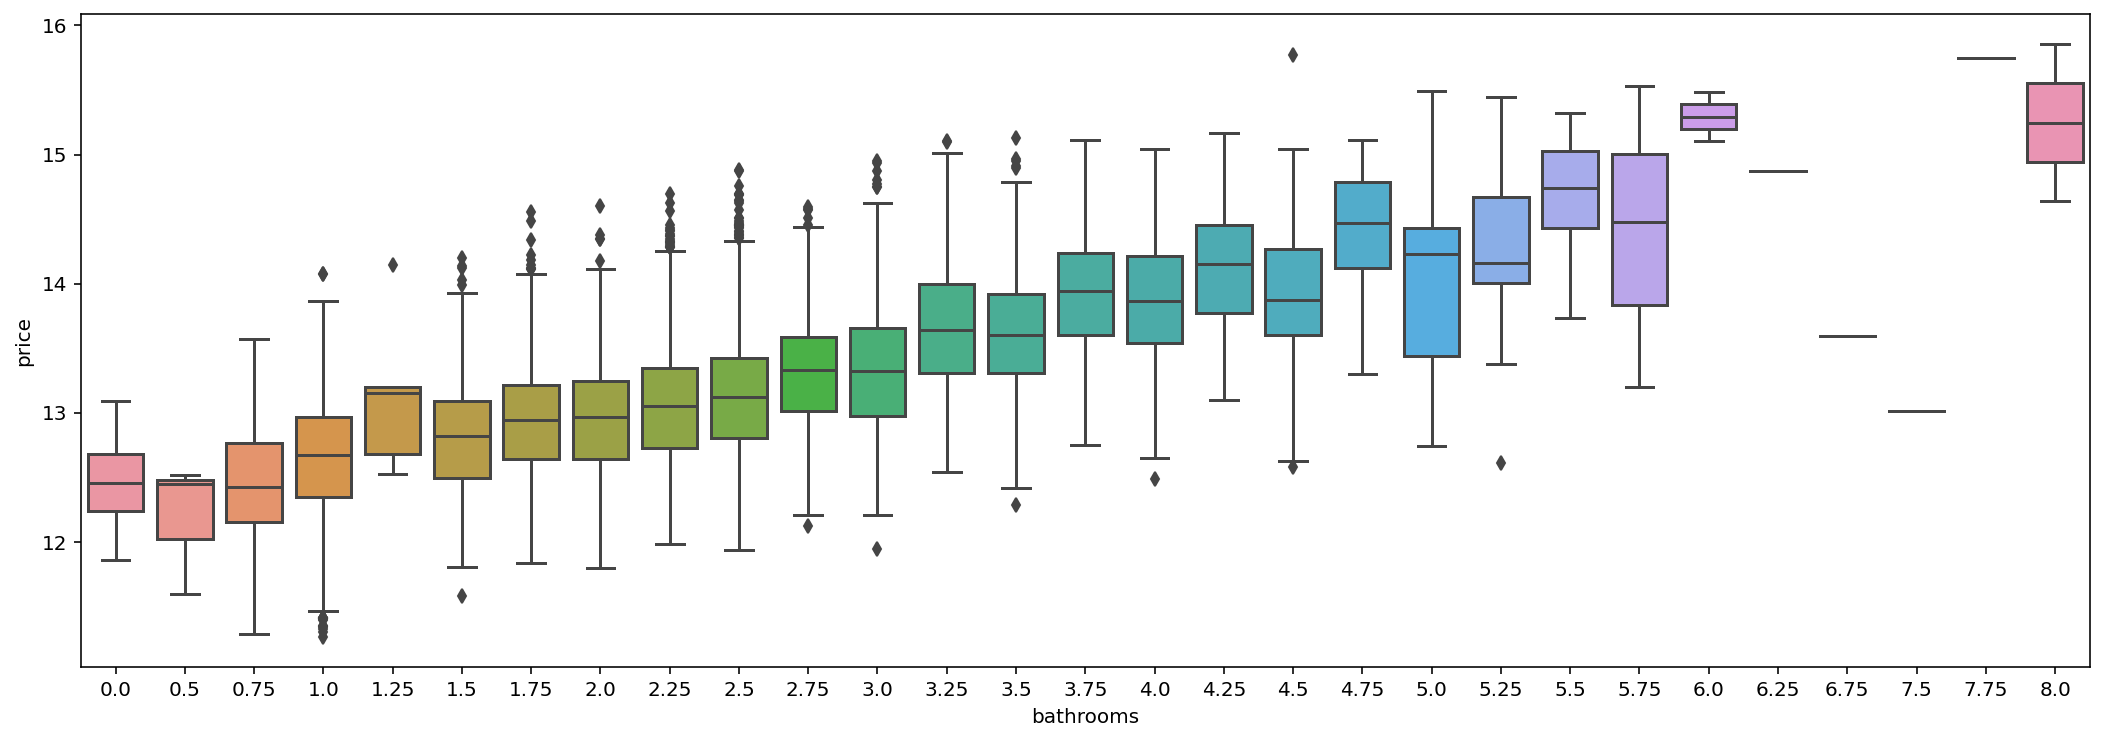

In [14]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

bathrooms같은경우 소숫점이 의미하는 값은 아래와 같다.
- 0.5 : 세면대, 화장실
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조

위의 그래프만을 가지고 각각의 값이 몇개있는지는 구분하기 어렵다.

## 2. 데이터 전처리

위에서 시각화하여 얻은 아래의 정보를 바탕으로 각 변수 마다 알맞게 전처리 과정을 실행한다.
- 1. 불필요한 정보인 `id` 컬럼 삭제
- 2. `date` 컬럼에서 연도와 월 정보를 정수형 데이터로 처리
- 3. `sqft_living` 컬럼에서  가격이 약 14 정도에 sqft_living이 14000에 가까운 값 이상치 처리
- 4. `grade` 컬럼에서 등급 3 의 경우 값이 큰 경우와 등급 8과 11에서 차이가 큰 이상치가 나타나는 경우 처리

### 불필요한 정보인 `id` 컬럼 삭제
훈련 데이터와 테스트 데이터에 각각 처리 한다.

In [15]:
del train['id']
del test['id']
print(train.shape)
print(test.shape)

(15035, 20)
(6468, 19)


### `date` 컬럼에서 연도와 월 정보를 정수형 데이터로 처리
훈련 데이터와 테스트 데이터에 각각 처리 한다.

In [16]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [17]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### `sqft_living` 컬럼 이상치 처리

위 데이터 시각화 과정에서 봤던 가격이 약 14 정도에 sqft_living 이 14000에 가까운 이상치 값을 삭제한다.

In [18]:
train.loc[train['sqft_living'] > 13000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


위의 표를 보면 `sqft_living` 이 13540으로 엄청 큰 값이 나온 것을 확인 할 수 있다.

In [19]:
train = train.loc[train['sqft_living']!=13540]

### `grade` 컬럼 이상치 처리
__등급 3 의 경우 값이 큰 경우__

In [20]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


가장 중요한 변수인 grade, sqft_ 모두 낮은 것을 볼 수 있다. 그래서 두 값 모두 이상치로 규정하고 제거한다.

__등급 8과 11에서 차이가 큰 이상치가 나타나는 경우__

In [21]:
train.loc[(train['price']>14.7) & (train['grade'] == 8)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,201408,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [22]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거한다.

In [23]:
train = train.drop([train.index[2302], train.index[4123], train.index[7173], train.index[2775]])

마지막으로 y 에 목표변수인 `price`를 저장하고 train 데이터에서 `price` 컬럼을 삭제한다.

In [24]:
y = train['price']
del train['price']

In [25]:
print(train.shape)
print(test.shape)

(15030, 19)
(6468, 19)


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15030 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15030 non-null  int64  
 1   bedrooms       15030 non-null  int64  
 2   bathrooms      15030 non-null  float64
 3   sqft_living    15030 non-null  int64  
 4   sqft_lot       15030 non-null  int64  
 5   floors         15030 non-null  float64
 6   waterfront     15030 non-null  int64  
 7   view           15030 non-null  int64  
 8   condition      15030 non-null  int64  
 9   grade          15030 non-null  int64  
 10  sqft_above     15030 non-null  int64  
 11  sqft_basement  15030 non-null  int64  
 12  yr_built       15030 non-null  int64  
 13  yr_renovated   15030 non-null  int64  
 14  zipcode        15030 non-null  int64  
 15  lat            15030 non-null  float64
 16  long           15030 non-null  float64
 17  sqft_living15  15030 non-null  int64  
 18  sqft_l

전체 데이처의 자료형이 모두 실수 또는 정수 자료형으로, 문제 없이 모델 학습에 활용할 수 있다.

## 3. HyperParameter - GridSearch

모델, 입력변수, 목표변수와 실험해볼 parameter grid 딕셔너리를 인자로 받아서 RMSLE 와 점수를 반환해주는 `my_GridSearch()` 함수를 만들자. 


`sklearn.model_selection` 라이브러리 안에 있는 `GridSearchCV` 클래스를 활용한다.

In [27]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### LGBMRegressor

In [28]:
random_state = 2020
param_grid = {
    'objective':['regression'],
    'learning_rate' : [0.05],
    'n_estimators':[50,100,200],
    'max_depth': [10,15,20,25],
    'num_iterations' : [1000]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   22.5s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   39.4s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,num_iterations,objective,score,RMSLE
3,0.05,15,50,1000,regression,-0.025798,0.160619
4,0.05,15,100,1000,regression,-0.025798,0.160619
5,0.05,15,200,1000,regression,-0.025798,0.160619
6,0.05,20,50,1000,regression,-0.025856,0.160798
7,0.05,20,100,1000,regression,-0.025856,0.160798
8,0.05,20,200,1000,regression,-0.025856,0.160798
9,0.05,25,50,1000,regression,-0.025856,0.160798
10,0.05,25,100,1000,regression,-0.025856,0.160798
11,0.05,25,200,1000,regression,-0.025856,0.160798
0,0.05,10,50,1000,regression,-0.025864,0.160823


### XGBRegressor

In [29]:
param_grid = {
    'learning_rate': [0.05],
    'subsample': [0.9],
    'n_estimators':[500, 1000],
    'max_depth': [5, 10]
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed: 73.6min finished


,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
1,0.05,5,1000,0.9,-0.025533,0.159791
2,0.05,10,500,0.9,-0.026025,0.161323
0,0.05,5,500,0.9,-0.026061,0.161435
3,0.05,10,1000,0.9,-0.026104,0.161567


### GradientBoostingRegressor

In [30]:
param_grid = {
    'learning_rate': [0.05],
    'subsample': [0.9],
    'n_estimators':[500,1000],
    'max_depth': [5, 10, 20]
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:  8.1min finished


,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
1,0.05,5,1000,0.9,-0.026028,0.161331
0,0.05,5,500,0.9,-0.026422,0.162547
2,0.05,10,500,0.9,-0.028442,0.168646
3,0.05,10,1000,0.9,-0.028451,0.168674
5,0.05,20,1000,0.9,-0.034120,0.184715
4,0.05,20,500,0.9,-0.034120,0.184715


## 4. 모델 학습 및 예측

다양한 모델로 gridsearch 를 하여 다양한 hyperparameter 를 실험해본 결과 __XGBoost__ 에서 다음의 hyperparameter 에서 최소의 손실값이 나왔다.  
- `learning_rate`: 0.05
- `subsample`: 0.9
- `n_estimators`: 1000
- `max_depth`: 5

In [39]:
best_param = {
    'learning_rate': 0.05,
    'subsample': 0.9,
    'n_estimators': 1000,
    'max_depth': 5
}

최적의 파라미터로 구성된 모델을 학습시키고 예측된 값을 csv 파일로 저장하는 `save_submission` 함수를 정의하자.

In [36]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [40]:
final_model= XGBRegressor(random_state=random_state,
                          learning_rate= 0.05,
                          subsample= 0.9,
                          n_estimators= 1000,
                          max_depth= 5)

In [41]:
save_submission(final_model, train, y, test, 'XGBoost', rmsle='0.0159')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGBoost_RMSLE_0.0159.csv saved!


## 5. 예측 파일 제출 및 점수 확인

저장된 `submission_XGBoost_RMSLE_0.0159.csv` 파일을 제출 후 점수를 확인하였다.  


![image](https://user-images.githubusercontent.com/84179578/127867618-6ac12c1f-e560-48ef-b70b-2f21f03bb34a.png)

결과 __109510점!__ 이 나왔다.  

basline 대로 해서 제출했을때 (약 129500점) 보다 약 20000점이 향상된 것을 알 수 있다.

# 프로젝트 정리

이번에 분석한 데이터는 20개의 변수를 가지고 있으며, 어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 모델을 만드는 것이 목표였다.  

처음 baseline 대로 진행하여 예측한 결과 __129500점__ 이 나왔다.

더 나아가 양질의 데이터 분석을 통해 예측을 보다 정확히 하기 위한 시도하였다.

- 데이터 탐색
  - 전체 데이터 확인 : 데이터 기본정보 파악(갯수, 특성 등), 결측치 파악
  - 목표 변수 `price` 정규화
  - 목표 변수`price` 와 각 변수 간의 상관관계 파악
  - 상관관계가 높은 5개의 변수 시각화 및 자세한 탐색

  
  
- 데이터 전처리
  - 위의 데이터 탐색 과정에서 얻은 정보를 바탕으로 데이터 전처리
  - `price` 예측에 불필요한 `id` 컬럼 삭제
  - `date` 컬럼에서 연도와 월 정보를 정수형 데이터로 처리
  - `sqft_living` 컬럼 이상치 처리
  - `grade` 컬럼 이상치 처리

  
  
- GridSearch 를 통해 최적의 Hyperparameter 검색
  - lightGBM, XGBoost, Gradient Boosting Regression 에 각각 최적의 Hyperparameter 검색 
  
  
  
위와 같은 과정으로 최종적으로 XGBoost 모델을 사용하여 예측을 한 결과 Kaggle 점수가 __109510점__ 이 나왔다.  

처음 나온 점수와 비교하여 약 20000점이 향상된 것을 확인 할 수 있다.

이후 더 점수를 향상시키려면 데이터 분석 과정에서 이번에 분석하지 못한 다양한 데이터들에 대해 분석하고 그에 맞게 데이터 전처리 과정을 가져야 할 것이다. 또한 더 많은 hyperparameter 와 더 다양한 모델로 실험해 볼 필요성이 있다.